# Transfer Learning

### Herramientas:
- Keras: https://keras.io/
- Tokenizer: https://keras.io/preprocessing/text/
- Model: https://keras.io/getting-started/sequential-model-guide/
- Dataset: http://qwone.com/~jason/20Newsgroups/
- GloVe Generics Embeddings: https://nlp.stanford.edu/projects/glove/

### Imports para todo el proyecto

In [1]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, Conv1D
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from random import shuffle

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Constantes para todo el proyecto

In [2]:
DATASET_PATH = '20news-18828/'
DATASET_LIRYCS_PATH = 'raw_lyrics/'
TEST_SIZE = 0.1
MAX_WORDS = 2000
BATCH_SIZE = 256
EPOCHS = 10
MODEL_FILENAME = 'model.json'
MODEL_WEIGHTS_FILENAME = 'model.h5'
EMBEDDINGS_FILENAME = 'glove.6B.100d.txt'
CPU_CORES = 4
PAD = 2000

#### Machete personal

- one epoch = one forward pass and one backward pass of all the training examples
- batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

# Primera parte:

## Entrenar una red neuronal para clasificar noticias

### Carga en memoria del dataset y preprocesado

In [3]:
dataset = {}
categories = os.listdir(DATASET_PATH)

for folder in categories:
    files = os.listdir(DATASET_PATH + folder)
    dataset[folder] = files

In [4]:
def load_document(filename):
    with open(filename, 'r', encoding="ISO--8859-1") as f:
        doc = f.read()
        doc = re.sub('\n', ' ', doc)
        #doc = re.sub("""[\)\(<>'"]""", '', doc)
        doc = re.sub('\d+', 'NUMBER', doc)
        doc = re.sub('\s+', ' ', doc).strip()
        
        return doc
        
#        result = [
#        for w in doc.split():
#            w = w.lower()
#            if not w in stopwords.words('english'):
#                result.append(w)            
#        result = ' '.join(result)
#    return result

In [5]:
def worker(key):
    train = []
    #test = []

    size = len(dataset[key])
    bound = int(size * (1 - TEST_SIZE))
    #for filename in dataset[key][:bound]:
    for filename in dataset[key]:
        doc = load_document(DATASET_PATH + key + '/' + filename)
        train.append((doc, categories.index(key)))
    #for filename in dataset[key][bound:]:
    #    doc = load_document(DATASET_PATH + key + '/' + filename)
    #    test.append((doc, categories.index(key)))
    
    print("Done", key)
    #return (train, test)
    return train
    
if __name__ == '__main__':
    keys = list(dataset.keys())
    p = Pool(CPU_CORES)
    result = p.map(worker, keys)
    p.close()
    
    train = []
    test = []
    
    for elem in result:
        train += elem
    
    shuffle(train)
    test = train[int(len(train) * 0.9):]
    train = train[:int(len(train) * 0.9)]

    del dataset
    del keys
    del p

Done misc.forsale
Done rec.sport.hockey
Done sci.space
Done rec.motorcycles
Done sci.med
Done comp.sys.mac.hardware
Done comp.graphics
Done soc.religion.christian
Done talk.politics.mideast
Done talk.politics.misc
Done sci.electronics
Done talk.politics.guns
Done comp.windows.x
Done rec.sport.baseball
Done alt.atheism
Done comp.sys.ibm.pc.hardware
Done sci.crypt
Done talk.religion.misc
Done rec.autos
Done comp.os.ms-windows.misc


In [6]:
def save_preprocessed_dataset():
    with open('preprocessed_dataset.json', 'w') as f:
        json.dump(train, f)
    with open('preprocessed_test.json', 'w') as f:
        json.dump(test, f)

def load_preprocessed_dataset():
    with open('preprocessed_dataset.json', 'r') as f:
        train = json.load(f)
    with open('preprocessed_test.json', 'r') as f:
        test = json.load(f)

In [7]:
save_preprocessed_dataset()

In [8]:
load_preprocessed_dataset()

In [9]:
tokenizer = Tokenizer(num_words=MAX_WORDS)

tokenizer.fit_on_texts([item[0] for item in train])

### Input y Output

Preparo el input y el output para entrenar la red y para su posterior testeo

In [10]:
matrix_train = tokenizer.texts_to_matrix([item[0] for item in train])
matrix_test = tokenizer.texts_to_matrix([item[0] for item in test])

In [11]:
y_train = to_categorical([item[1] for item in train], len(categories))
y_test = to_categorical([item[1] for item in test], len(categories))

### Estructura de la red

In [12]:
model_normal = Sequential()
model_normal.add(Dense(64, input_shape=(MAX_WORDS,)))
model_normal.add(Activation('relu'))
model_normal.add(Dropout(0.6))
model_normal.add(Dense(len(categories)))
model_normal.add(Activation('softmax'))

model_normal.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_normal.summary()

data_normal = [[],[],[],[]]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                128064    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
Total params: 129,364
Trainable params: 129,364
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento de la red

In [13]:
def plt_history(data):
    plt.title('Model accuracy')
    for i in data[:2]:
        plt.plot(i)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'])
    plt.show()
    plt.title('Model accuracy')
    for i in data[2:]:
        plt.plot(i)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [14]:
def train_model(model, x_train, y_train, batch_size, epochs, data):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    data[0] += history.history['acc']
    data[1] += history.history['val_acc']
    data[2] += history.history['loss']
    data[3] += history.history['val_loss']
    return data

In [ ]:
data_normal = train_model(model_normal, matrix_train, y_train, BATCH_SIZE, 10, data_normal)

score = model_normal.evaluate(matrix_test, y_test,
                   batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

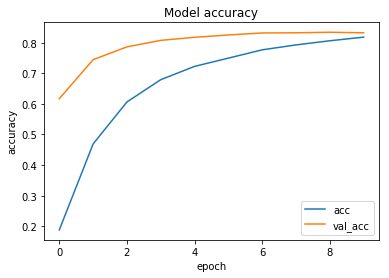

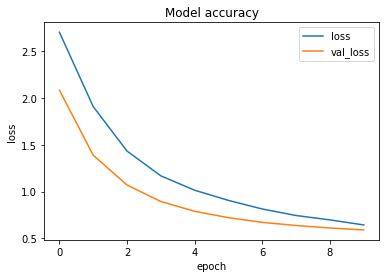

In [16]:
plt_history(data_normal)

### Predicciones

In [17]:
def print_predictions(predictions):
    for pred in predictions:
        pred_cat = []
        for i in range(len(pred)):
            pred_cat.append((pred[i], categories[i]))
        result = sorted(pred_cat, key=lambda x: -x[0])
        print("=============")
        for elem in result:
            if elem[0] >= 0.01:
                print(elem)

def clasificar_normal(texto):
    matrix_probar = tokenizer.texts_to_matrix(texto)
    predictions = model_normal.predict(matrix_probar, batch_size=BATCH_SIZE)
    return predictions

### Ejemplo de prediccion con noticia actual de CNN
http://edition.cnn.com/2017/11/12/us/texas-church-service-memorial/index.html

In [18]:
cnn_text = """
Sutherland Springs, Texas (CNN)The congregation of First Baptist Church of Sutherland Springs held a service on Sunday, one week after a gunman opened fire in the church, killing 25 people and an unborn child in the deadliest mass shooting in Texas history.

Sunday's service was held just a few blocks away from the church beneath a white tent on a baseball field, closely guarded by Texas Department of Public Safety agents, sheriff's deputies and emergency management officers.
Attendees filled about 500 seats in the makeshift sanctuary, which held a small podium for Sunday's speakers and a wooden cross enveloped white lights. The remaining guests stood in the back.
Security becomes a top priority for churches after Texas massacre
Pastors and churches from around the area organized the service, while First Baptist Church's pastor, Frank Pomeroy -- whose 14-year-old daughter was killed in the shooting -- spoke.
Pomeroy urged those gathered to "choose life," rather than "darkness" as the gunman had.
"Victory has a price," he told them. "You cannot be victorious in battle without being wounded in battle."
At one point, Pomeroy began to break down while speaking.
"I know everyone who lost their life that day," he said, "some of which were my best friends, and my daughter, and I guarantee without any shadow of a doubt they are dancing with Jesus today. God gets the glory."
Read more: Why the church shooting hasn't changed rural Texans' minds about guns
Texas Sen. John Cornyn also made remarks during the service.
"It's clear they're people of deep faith," Cornyn said of the congregation in an impromptu press conference following the service. "And that's what sustains them and gives them hope, even during dark times like this."
Cornyn spoke highly of Pomeroy and his faith, which endures despite having suffered his own tragic loss.
"I saw him standing there at the front of the church, comforting others," Cornyn said. "It's remarkable, but it's a testament to their faith and their compassion for others during this very difficult time."
People from around the state and distant corners of the country traveled to show their support for the small Texas community, home to about 600 residents. One man drove from Dallas, while another couple told CNN they drove from North Carolina.
Texas church to open as memorial one week after mass shooting
The church's services were typically attended by no more than several dozen people, who gathered within the church's white walls, singing hymns led by a small worship band.
On Saturday, the church announced the sanctuary would be open to the public on Sunday evening, having been "transformed into a beautiful memorial that celebrates and pays tribute to the lives that were lost."
"I want everyone that walks in there to know that the people who died lived for their Lord and savior, and would want them to live as well," Pomeroy said Sunday afternoon.
Next Sunday's church service will return to the sanctuary where last week's attack was carried out, and Sunday school classes will resume, former associate pastor Mark Collins announced at the end of the service.
"""
cnn_text = re.sub('\n', ' ', cnn_text)
cnn_text = re.sub('\d+', 'NUMBER', cnn_text)
cnn_text = re.sub('\s+', ' ', cnn_text).strip()

In [19]:
predictions = clasificar_normal([cnn_text])
print_predictions(predictions)
del predictions

(0.41406578, 'soc.religion.christian')
(0.20123458, 'talk.politics.guns')
(0.17809494, 'talk.religion.misc')
(0.10927631, 'talk.politics.misc')
(0.056979336, 'rec.sport.baseball')
(0.015246461, 'alt.atheism')


### Guardo el modelo y los pesos en disco

In [20]:
def save_model_weights(model, filename):
    # serialize model to JSON
    model_json = model.to_json()
    with open(filename + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filename + '.h5')
    print("Saved model to disk")

## Mejoras que se podrian hacer

- Quitar STOPWORDS

# Parte 2

## Aplicar lo entrenado para clasificar canciones

### Cargo el dataset de canciones

In [21]:
songs_filename = os.listdir(DATASET_LIRYCS_PATH)

def load_song_document(filename):
    with open(filename, 'r') as f:
        doc = f.read()
        doc = re.sub('\n', ' ', doc)
        #doc = re.sub('\s+', ' ', doc).strip()
    
    return doc

songs = []

for song in songs_filename:
    songs.append(load_song_document(DATASET_LIRYCS_PATH + "/" + song))

del songs_filename

### Clasificar canciones

In [22]:
predictions = clasificar_normal(songs)

In [23]:
def get_best_predictions(predictions):
    pred_cat = []
    for i in range(len(predictions)):
        pred_cat.append((predictions[i], categories[i]))
    result = sorted(pred_cat, key=lambda x: -x[0])
    result = [x for x in result if x[0] >= 0.6]
    return result

song_pred = []

for i in range(len(songs)):
    song_pred.append((songs[i], get_best_predictions(predictions[i])))

### Muestro las clasificadas con mayor seguirdad

In [24]:
def show_securely_pred_songs(songs_pred):
    for song in song_pred:
        if len(song[1]) > 0:
            print(song[0])
            print(song[1])
            print("""\n===================\n""")

In [25]:
show_securely_pred_songs(predictions)
del predictions

Easy Easy Take love easy, easy easy Never let your feelings show Make it breezy, breezy breezy Easy come and easy go  Never smile too brightly brightly When your heart is riding high Let your heart break, oh so slightly When your baby says goodbye  That well known flame is mighty hot As all of us have learned So handle it with velvet gloves And you won't get your fingers burned  Take love easy, easy On the free and easy plan And if you can't take it easy Take it easy as you can  Take love easy, easy Never let your feelings show Make it breezy, breezy, easy Easy, easy come and easy go  Never smile too brightly brightly When your heart is riding high Let your heart break, oh so slightly When your baby says goodbye  That well known flame is mighty hot As all of us have learned So handle it, handle it with velvet gloves And you won't get your fingers burned  Take love easy, easy easy On the free and easy plan And if you can't take it easy Take it easy as you can  Take it easy Take it easy 

## Aplicacion con Embedding Genericos

In [ ]:
with open(EMBEDDINGS_FILENAME, 'r') as f:
    raw_embeddings = f.readlines()

embeddings_index = {}
    
for line in raw_embeddings:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in tokenizer.word_index:
        embeddings_index[word] = coefs
        
del raw_embeddings

In [ ]:
enconded_train = tokenizer.texts_to_sequences([item[0] for item in train])
enconded_test = tokenizer.texts_to_sequences([item[0] for item in test])

padded_train = pad_sequences(enconded_train, PAD, padding='post')
padded_test = pad_sequences(enconded_test, PAD, padding='post')

del doc_train
del enconded_test

In [ ]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

del embeddings_index

In [ ]:
model_emb = Sequential()
model_emb.add(Embedding(vocab_size, 100, input_length=PAD, weights=[embedding_matrix], trainable=False))
model_emb.add(Conv1D(64, 5))
model_emb.add(Activation('relu'))
model_emb.add(Flatten())
model_emb.add(Dropout(0.5))
model_emb.add(Dense(len(categories)))
model_emb.add(Activation('softmax'))

model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

data_emb = [[],[],[],[]]

In [ ]:
model_emb.summary()

In [ ]:
data_emb = train_model(model_emb, padded_train, y_train, BATCH_SIZE, 5, data_emb)

score = model_emb.evaluate(padded_test, y_test,
                   batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
def clasificar_emb(texto):
    enconde_text = tokenizer.texts_to_sequences(texto)
    padded_text = pad_sequences(enconde_text, PAD, padding='post')
    predictions = model_emb.predict(padded_text, batch_size=BATCH_SIZE)
    return predictions

In [ ]:
predictions = clasificar_emb([cnn_text])
print_predictions(predictions)

In [ ]:
predictions = clasificar_emb(songs)

In [ ]:
show_securely_pred_songs(predictions)